## BiLSTM : 19th Plath Best Single Model [ CV:0.1302 LB:0.1147 ]


### Abstract
1. Feature Engineering
    - Logarithmized u_in from the beginning
    - First and second derivative for u_in
    - RobustScaler fit features with u_out==0 only


2. Model
    - BiLSTM with ResNet-like structure
    - Custom MAE Loss
    - optimizer : AdamW
    - scheduler : ReduceLrOnPlateum


3. Post-Processing
    - We used [Chris's PP](https://www.kaggle.com/cdeotte/ensemble-folds-with-median-0-153)


### Common pipeline between Colab and kaggle

1. The exact same code can be used between google colab & kaggle 

2. You can use the kaggle api to automatically load data and submit, and upload datasets

3. Parallel fold training with multiple sessions is possible on colab

4. Both TPU and GPU can be used

## Config

In [1]:
class Config:
    name_v1 = "Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune"  
    editor = "masato8823"
    api_path = "/content/drive/masato8823/kaggle.json"
    finetune = "Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025"  # This code is after finetuning
    lr = 1e-3
    weight_decay = 2e-5
    epochs = 512
    scheduler = "ReduceLROnPlateau"  # : ReduceLROnPlateau: CosineDecayRestarts
    early_stop = True
    seq_len = 80
    masking = False
    steps_per_epochs = None
    train_batch_size = 256
    valid_batch_size = 1024
    test_batch_size = 1024
    n_fold = 30
    trn_fold = list(range(30))
    seed = 2025
    target_col = "pressure"
    debug = False

    # Colab Env
    submit_from_colab = False
    upload_from_colab = False
    
    # Kaggle Env
    kaggle_dataset_path = "../input/exp-102"

if Config.debug:
    Config.epochs = 2
    Config.trn_fold = [0]

## Library

In [2]:
!pip install -U -q scikit-learn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.1 which is incompatible.


In [3]:
import os
import sys
import joblib
import logging
import warnings
import datetime
import json
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from requests import get
from sklearn import model_selection
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Bidirectional, LSTM

2021-11-04 08:48:32.863659: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-04 08:48:32.863781: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# ========================================
# Utils
# ========================================

class Logger:
    """save log"""
    def __init__(self, path):
        self.general_logger = logging.getLogger(path)
        stream_handler = logging.StreamHandler()
        file_general_handler = logging.FileHandler(os.path.join(path, 'Experiment.log'))
        if len(self.general_logger.handlers) == 0:
            self.general_logger.addHandler(stream_handler)
            self.general_logger.addHandler(file_general_handler)
            self.general_logger.setLevel(logging.INFO)

    def info(self, message):
        # display time
        self.general_logger.info('[{}] - {}'.format(self.now_string(), message))

    @staticmethod
    def now_string():
        return str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    
class Util:
    """save & load"""
    @classmethod
    def dump(cls, value, path):
        joblib.dump(value, path, compress=True)

    @classmethod
    def load(cls, path):
        return joblib.load(path)
    
    
class HorizontalDisplay:
    """display dataframe"""
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        template = '<div style="float: left; padding: 10px;">{0}</div>'
        return "\n".join(template.format(arg._repr_html_())
                         for arg in self.args)
    
    
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    dfs = []
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dfs.append(df[col].astype(np.int8))
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dfs.append(df[col].astype(np.int16))
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dfs.append(df[col].astype(np.int32))
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dfs.append(df[col].astype(np.int64) ) 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dfs.append(df[col].astype(np.float32))
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dfs.append(df[col].astype(np.float32))
                else:
                    dfs.append(df[col].astype(np.float64))
        else:
            dfs.append(df[col])
    
    df_out = pd.concat(dfs, axis=1)
    if verbose:
        end_mem = df_out.memory_usage().sum() / 1024**2
        num_reduction = str(100 * (start_mem - end_mem) / start_mem)
        print(f'Mem. usage decreased to {str(end_mem)[:3]}Mb:  {num_reduction[:2]}% reduction')
    return df_out

## SetUp

In [5]:
COLAB = "google.colab" in sys.modules

if COLAB:
    print("This environment is Google Colab")

    # install pack
    ! pip install --quiet category_encoders
    ! pip install --quiet tensorflow_addons

    # mount
    from google.colab import drive, files
    drive.mount('/content/drive') 

    # use kaggle api (need kaggle token)
    f = open(Config.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

    DRIVE = f"/content/drive/{Config.editor}"  # set directory path
    EXP = Config.name_v1 if Config.name_v1 is not None else get("http://172.28.0.2:9000/api/sessions").json()[0]["name"][:-6]  # get notebook name
    INPUT = os.path.join(DRIVE, "Input")
    OUTPUT = os.path.join(DRIVE, "Output")
    SUBMISSION = os.path.join(DRIVE, "Submission")
    OUTPUT_EXP = os.path.join(OUTPUT, EXP) 
    EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)

    if not os.path.isfile(os.path.join(INPUT, "train.csv.zip")):
        # load dataset
        ! kaggle competitions download -c ventilator-pressure-prediction -p $INPUT 
    
    # utils
    logger = Logger(OUTPUT_EXP)

else:
    print("This environment is Kaggle Kernel")
    INPUT = "../input/ventilator-pressure-prediction"

    EXP, OUTPUT, SUBMISSION = "./", "./", "./"
    EXP_MODEL = os.path.join(EXP, "model")
    EXP_FIG = os.path.join(EXP, "fig")
    EXP_PREDS = os.path.join(EXP, "preds")

    if Config.kaggle_dataset_path is not None:
        KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
        KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
        shutil.copytree(KD_MODEL, EXP_MODEL)
        shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # make dirs
    for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)
        
    # utils
    logger = Logger(EXP)

# utils
warnings.filterwarnings("ignore")
sns.set(style='whitegrid')

# tpu
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', TPU.master())
except ValueError:
    TPU = None

# 2nd import
import category_encoders as ce
import tensorflow_addons as tfa

This environment is Kaggle Kernel
Running on TPU  grpc://10.0.0.2:8470


## Load Data

In [6]:
train_name = "train.csv.zip" if COLAB else "train.csv"
test_name = "test.csv.zip" if COLAB else "test.csv"
sub_name = "sample_submission.csv.zip" if COLAB else "sample_submission.csv"

train = pd.read_csv(os.path.join(INPUT, train_name))
test = pd.read_csv(os.path.join(INPUT, test_name))
sample_submission = pd.read_csv(os.path.join(INPUT, sub_name))

# fisrt, add fold index
train["fold"], test["fold"] = -1, -1
for i, lst in enumerate(
    model_selection.StratifiedGroupKFold(
        n_splits=Config.n_fold, 
        shuffle=True,
        random_state=Config.seed).split(X=train, 
                                        y=train['R'].astype(str) + train['C'].astype(str), 
                                        groups=train["breath_id"])):
    if i in Config.trn_fold:
        train.loc[lst[1].tolist(), "fold"] = i

if Config.debug:
    train = train[train["breath_id"].isin(np.random.choice(train["breath_id"].unique(), 1000))].reset_index(drop=True)
    test = test[test["breath_id"].isin(np.random.choice(test["breath_id"].unique(), 1000))].reset_index(drop=True)
    sample_submission = sample_submission[sample_submission["id"].isin(test["id"].tolist())].reset_index(drop=True)
    
test[Config.target_col] = np.nan

# cut seq
train = train[train.groupby('breath_id')['time_step'].cumcount() < Config.seq_len].reset_index(drop=True)
test = test[test.groupby('breath_id')['time_step'].cumcount() < Config.seq_len].reset_index(drop=True)

## Simple EDA

In [7]:
def plot_pressure_line(train, breath_ids=None, additional_cols=None):
    if breath_ids is None:
        breath_ids = train["breath_id"].unique()[:12].tolist()
        
    fig, axes = plt.subplots(figsize=(25, 18), ncols=4, nrows=3)
    axes = np.ravel(axes)
    plot_cols = ["pressure", "u_in", "u_out"]
    
    if additional_cols:
        plot_cols += additional_cols
        
    for b, ax in zip(breath_ids, axes):
        _df = train[train["breath_id"]==b].copy()
        (_df
         .set_index("time_step")[plot_cols]
         .plot(colormap='Paired',
               ax=ax,
               title=f"breath_id={b}, R={_df['R'].unique()}, C={_df['C'].unique()}", 
               linewidth=2)
        )

    fig.subplots_adjust(hspace=0.3)
    return fig


def plot_pressure_line_px(input_df, breath_id, additional_cols=[]):
    cols = ["pressure",  "u_in", "u_out"] + additional_cols
    breath_df = input_df[input_df["breath_id"]==breath_id]
    plot_df = pd.DataFrame()
    for col in cols:
        _df = breath_df[cols].rename(columns={col:"y"})
        _df["time_step"] = breath_df["time_step"].values
        _df["color"] = col
        plot_df = pd.concat([plot_df, _df])
    fig = px.line(plot_df, x="time_step", y="y", color="color",
                  title=f"breth_id={breath_id}, R={breath_df['R'].unique()}, C={breath_df['C'].unique()}")
    fig.update_traces(mode='markers+lines')
    return fig

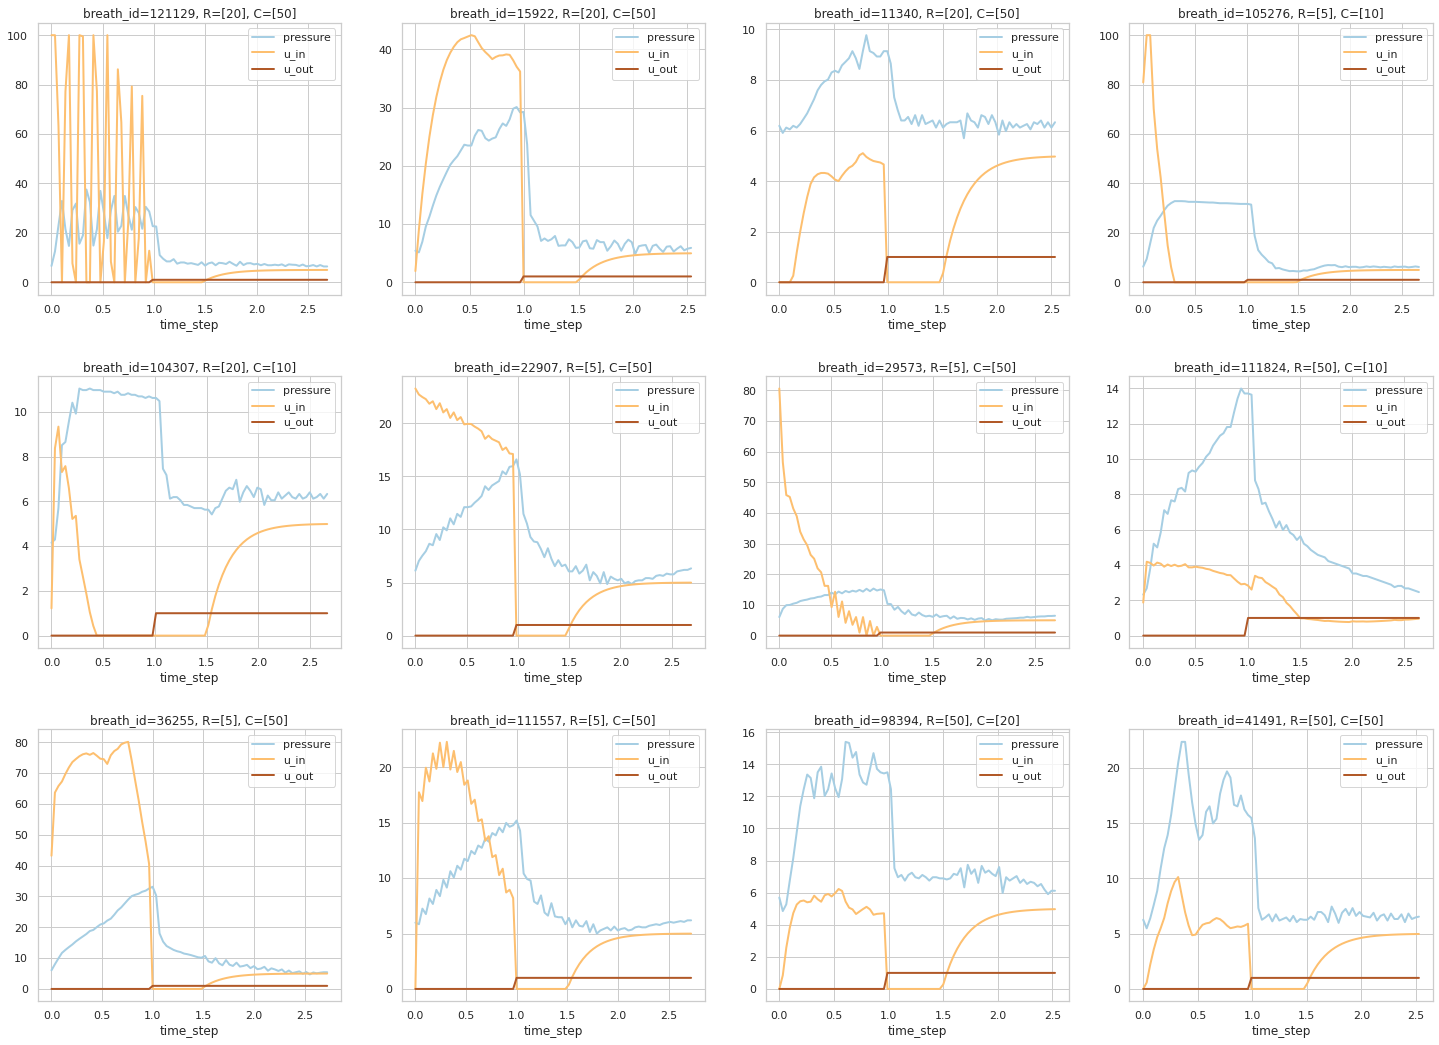

In [8]:
breath_ids = list(train["breath_id"].sample(12))
fig = plot_pressure_line(train, breath_ids, additional_cols=[])

In [9]:
fig = plot_pressure_line_px(input_df=train, breath_id=train["breath_id"].sample(1).values[0], additional_cols=[])
fig.show()

## Feature Engineering

In [10]:
def aggregation(input_df, group_key, group_values, agg_methods):
    """ref:https://github.com/pfnet-research/xfeat/blob/master/xfeat/helper.py"""
    new_df = []
    for agg_method in agg_methods:
        for col in group_values:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            new_col = f"agg_{agg_method_name}_{col}_grpby_{group_key}"
            df_agg = (input_df[[col] + [group_key]].groupby(group_key)[[col]].agg(agg_method))
            df_agg.columns = [new_col]
            new_df.append(df_agg)
            
    _df = pd.concat(new_df, axis=1).reset_index()
    output_df = pd.merge(input_df[[group_key]], _df, on=group_key, how="left")
    return output_df.drop(group_key, axis=1)


def get_raw_features(input_df):
    cols = [
        "time_step",
        "u_in",
    ]
    output_df = input_df[cols].copy()
    return output_df


def get_ohe_features(input_df):
    cols = ["R", "C"]
    encoder = ce.OneHotEncoder()
    output_df = encoder.fit_transform(input_df[cols].astype(str))
    return output_df


def get_fold_value(input_df):
    return input_df[["fold"]]


def get_target_value(input_df):
    return input_df[[Config.target_col]]


def get_cumlative_grpby_breath_id_features(input_df):
    
    input_df["area"] = input_df["time_step"] * input_df["u_in"]
    group_key = "breath_id"
    group_values = ["u_in", "area"]
    
    output_df = pd.DataFrame()
    for group_val in group_values:
        col_name = f"agg_cumsum_{group_val}_grpby_{group_key}"
        output_df[col_name] = input_df.groupby(group_key)[group_val].cumsum()
    
    # tubotubo feats
    output_df["divede_cumsum_u_in_by_time_step"] = np.log1p(output_df["agg_cumsum_u_in_grpby_breath_id"] /
                                                    (input_df["time_step"] + 1e-2))
        
    return output_df.fillna(0)


def get_mask_feature(input_df):
    output_df = pd.DataFrame()
    output_df["mask"] = input_df["u_out"] == 0
    return output_df


def _get_agg_col_name(group_key, group_values, agg_methods):
    out_cols = []
    for group_val in group_values:
        for agg_method in agg_methods:
            out_cols.append(f"agg_{agg_method}_{group_val}_grpby_{group_key}")
    return out_cols


def get_shift_grpby_breath_id_features(input_df):
    shift_times = [1, 2, 3, 4]
    group_key = "breath_id"
    group_values = ["u_in"]
    
    output_df = pd.DataFrame()
    for t in shift_times:
        _df = input_df.groupby(group_key)[group_values].shift(t)
        _df.columns = [f'shift={t}_{col}_grpby_{group_key}' for col in group_values]
        output_df = pd.concat([output_df, _df], axis=1)
    return output_df.fillna(0)


def get_diff_grpby_breath_id_features(input_df):
    diff_times = [1, 2, 3, 4]
    group_key = "breath_id"
    group_values = ["time_step", "u_in"]
    
    output_df = pd.DataFrame()
    output_df["breath_id"] = input_df["breath_id"].copy()

    for t in diff_times:
        _df = input_df.groupby(group_key)[group_values].diff(t)
        _df.columns = [f'diff={t}_{col}_grpby_{group_key}' for col in group_values]
        output_df = pd.concat([output_df, _df], axis=1)

    # 1st derivative
    for n in [1]:
        col = f'slope={n}_time_step_u_in'
        val = (output_df[f'diff={n}_u_in_grpby_breath_id'] /
               (output_df[f'diff={n}_time_step_grpby_breath_id'] + 1e-8))
        output_df[col] = val
               
    return output_df.fillna(0).drop("breath_id", axis=1)


def get_accel_grpby_breath_id_feature(input_df):
    grby_u_in = input_df.groupby('breath_id')['u_in']
    grby_time_step = input_df.groupby('breath_id')['time_step']
    
    # 2nd derivative
    output_df = pd.DataFrame()
    output_df["accel"] = ((grby_u_in.shift(0) - 2 * grby_u_in.shift(1) + grby_u_in.shift(2)) /
                 (grby_time_step.diff(1) * grby_time_step.diff(1).shift(1)))

    # clip accel
    p001 = output_df["accel"].quantile(0.01)
    p099 = output_df["accel"].quantile(0.99)
    output_df["accel"] = output_df["accel"].clip(p001, p099)
    
    return output_df.fillna(0)


def get_features_df(train, test):
    whole_df = pd.concat([train, test]).reset_index(drop=True)
    whole_df["u_in"] = np.log1p(whole_df["u_in"])  
    output_df = pd.DataFrame()
    
    funcs = [
        get_target_value,
        get_mask_feature,
        get_fold_value,
        get_raw_features,
        get_ohe_features,
        get_cumlative_grpby_breath_id_features,
        get_shift_grpby_breath_id_features,
        get_diff_grpby_breath_id_features,
        get_accel_grpby_breath_id_feature,
    ]

    for func in funcs:
        print(func.__name__)
        _df = func(whole_df)
        if func.__name__ not in [
                                 "get_mask_feature",
                                 "get_target_value",
                                 "get_fold_value" 
                                 ]:

            scaler = RobustScaler()
            _df[whole_df["u_out"]==0] = scaler.fit_transform(_df[whole_df["u_out"]==0])
            _df[whole_df["u_out"]==1] = scaler.transform(_df[whole_df["u_out"]==1])
            _df = reduce_mem_usage(_df)
            
        output_df = pd.concat([output_df, _df], axis=1)
    
    output_df["breath_id"] = whole_df["breath_id"].copy()
    train_feats_df = output_df.iloc[:len(train)]
    test_feats_df = output_df.iloc[len(train):].reset_index(drop=True)
    
    return train_feats_df, test_feats_df

## Model

In [11]:
def masked_mae_loss(y_true, y_pred, loss_mask):
    y_true_0 = tf.boolean_mask(y_true, tf.cast(loss_mask, dtype=tf.bool))
    y_pred_0 = tf.boolean_mask(y_pred, tf.cast(loss_mask, dtype=tf.bool))
    score = tf.keras.losses.mean_absolute_error(y_true_0, y_pred_0)
    return score


def custom_mae_loss(y_true, y_pred, loss_mask):
    y_true_0 = tf.boolean_mask(y_true, tf.cast(loss_mask, dtype=tf.bool))
    y_pred_0 = tf.boolean_mask(y_pred, tf.cast(loss_mask, dtype=tf.bool))
    score_0 = tf.keras.losses.mean_absolute_error(y_true_0, y_pred_0)

    y_true_1 = tf.boolean_mask(y_true, tf.cast(1 - loss_mask, dtype=tf.bool))
    y_pred_1 = tf.boolean_mask(y_pred, tf.cast(1 - loss_mask, dtype=tf.bool))
    score_1 = tf.keras.losses.mean_absolute_error(y_true_1, y_pred_1)
    score = score_0 * 2 + score_1 * 1
    return score


def build_model(input_shape, only_inference=False):
    
    inputs_x = tf.keras.layers.Input(shape=input_shape, name="input_x")
    inputs_y = tf.keras.layers.Input(shape=(input_shape[0], 1), name="input_y")
    inputs_w = tf.keras.layers.Input(shape=(input_shape[0], 1), name="input_w")

    x0 = Bidirectional(LSTM(512, return_sequences=True))(inputs_x)
    x = tf.keras.layers.Concatenate(axis=2)([inputs_x, x0])

    x1 = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Concatenate(axis=2)([x0, x1])

    x2 = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = tf.keras.layers.Concatenate(axis=2)([x1, x2])

    x3 = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = tf.keras.layers.Concatenate(axis=2)([x2, x3])

    x4 = Bidirectional(LSTM(512, return_sequences=True))(x)
    
    x = tf.keras.layers.Concatenate(axis=2)([x0, x1, x2, x3, x4])
    x = tf.keras.layers.Dense(64, activation="selu")(x)
    
    x = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=[inputs_x, inputs_y, inputs_w], outputs=x)
    
    if not only_inference:
        model.add_loss(custom_mae_loss(inputs_y, x, inputs_w))
        model.add_metric(masked_mae_loss(inputs_y, x, inputs_w), name="masked_mae")

    optimizer = tfa.optimizers.AdamW(lr=Config.lr, weight_decay=Config.weight_decay)
    model.compile(optimizer=optimizer)
    return model


def get_model(input_shape, only_inference=False):
    # TPU setting
    if TPU:
        if COLAB:  # tpu in colab
            tf.config.experimental_connect_to_cluster(TPU)
            tf.tpu.experimental.initialize_tpu_system(TPU)
            tpu_strategy = tf.distribute.experimental.TPUStrategy(TPU)

        else:  # tpu in kaggle kernel
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
            tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

        with tpu_strategy.scope():
            model = build_model(input_shape, only_inference)

    else:
        model = build_model(input_shape, only_inference)
    
    return model

## Funcs

In [12]:
NO_FEATURES = ["breath_id", "mask", "fold", Config.target_col]

# ========================================
# DataLoader
# ========================================
def get_dataset(X, y=None, dataset="test"):
    
    if dataset=="train":
        train_dataset = (
            tf.data.Dataset
            .from_tensor_slices((X, y))
            .shuffle(10**8)
            .batch(Config.train_batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
            )
        if Config.steps_per_epochs is not None:
            train_dataset = train_dataset.repeat()
        return train_dataset

    elif dataset=="valid":
        valid_dataset = (
            tf.data.Dataset
            .from_tensor_slices((X, y))
            .batch(Config.valid_batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )
        return valid_dataset
    
    elif dataset=="test":
        test_dataset = (
            tf.data.Dataset
            .from_tensor_slices(X)
            .batch(Config.test_batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )
        return test_dataset
    
    else:
        raise NotImplementedError


def transform_features_for_rnn(input_df, feature_names='__all__'):
    if feature_names == "__all__":
        feature_names = input_df.columns.tolist()

    features = []
    _input_df = input_df.copy()
    _input_df['time_index'] = _input_df.groupby('breath_id')['time_step'].cumcount()
    _input_df = _input_df.query('time_index < @Config.seq_len' ).reset_index(drop=True)
    use_cols = list(set(feature_names) - set(['breath_id', 'mask', 'fold']))
    
    if Config.masking:
        # pad 0 in u_out==1
        _input_df.loc[~input_df["mask"], use_cols] = -1

    pdf = pd.pivot_table(data=_input_df, index='breath_id', columns='time_index')
    breath_id_count = len(pdf)

    for feat_name in feature_names:
        if feat_name in NO_FEATURES:
            continue
            
        _feat = pdf[feat_name].values.reshape(breath_id_count, -1, 1)
        features.append(_feat)

    features = np.concatenate(features, axis=2)
    print(features.shape)
    return features
    

def transform_target_for_rnn(train, target_col=Config.target_col):
    _train = train.copy()
    _train['time_index'] = _train.groupby('breath_id')['time_step'].cumcount()
    _train = _train.query('time_index < @Config.seq_len').reset_index(drop=True)

    if target_col != 'mask':
        if Config.masking:
            _train.loc[~train['mask'], Config.target_col] = -1

    pdf = pd.pivot_table(data=_train, index='breath_id', columns='time_index', values=[target_col])
    breath_id_count = len(pdf)
    target = pdf[target_col].values.reshape(breath_id_count, -1, 1)
    return target


# ========================================
# Scheduler
# ========================================
def get_scheduler(monitor):
    if Config.scheduler == "custom-v1":
        def custom_scheduler(epoch):
            x = Config.lr
            if epoch >= 125: x = 0.0007
            if epoch >= 185: x = 0.0004
            if epoch >= 250: x = 0.0003
            if epoch >= 275: x = 0.0002
            if epoch >= 290: x = 0.00015
            if epoch >= 305: x = 0.0001
            if epoch >= 320: x = 0.000075
            if epoch >= 325: x = 0.00006
            if epoch >= 330: x = 0.00004
            if epoch >= 330: x = 0.00003
            if epoch >= 340: x = 0.00002
            if epoch >= 345: x = 0.00001
            return x
        
        # plot steps
        plt.plot([custom_scheduler(i) for i in range(Config.epochs)])
        plt.show()
        scheduler = tf.keras.callbacks.LearningRateScheduler(custom_scheduler, verbose=1)
    
    elif Config.scheduler == "ReduceLROnPlateau":
        scheduler = tf.keras.callbacks.ReduceLROnPlateau(
            monitor=monitor, 
            factor=0.7,
            patience=16,
            min_lr=1e-7, 
            verbose=1
            )
        
    elif Config.scheduler == "CosineDecayRestarts":
        cisine_decay_r = tf.keras.experimental.CosineDecayRestarts(
            Config.lr,
            first_decay_steps=Config.epochs // 2,
            t_mul=1,
            m_mul=1,
            alpha=0.01
            )
        
        # plot steps
        plt.plot([cisine_decay_r(i) for i in range(Config.epochs)])
        plt.show()

        scheduler = tf.keras.callbacks.LearningRateScheduler(cisine_decay_r, verbose=1)
    
    else:
        raise NotImplementedError
    
    return scheduler

# ========================================
# Training & Inference Func
# ========================================
def training_rnn(train_df, valid_df, model, filepath):
    """Training func for RNN"""

    train_x = transform_features_for_rnn(train_df)
    valid_x = transform_features_for_rnn(valid_df)
    train_y = transform_target_for_rnn(train_df)
    valid_y = transform_target_for_rnn(valid_df)
    
    train_w = transform_target_for_rnn(train_df, "mask")
    valid_w = transform_target_for_rnn(valid_df, "mask")
    train_inputs = {"input_x":train_x, "input_y":train_y, "input_w":train_w}
    valid_inputs = {"input_x":valid_x, "input_y":valid_y, "input_w":valid_w}
    
    tr_dataset = get_dataset(X=train_inputs, y=train_y, dataset="train")
    va_dataset = get_dataset(X=valid_inputs, y=valid_y, dataset="valid")
    
    monitor = "val_masked_mae"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor=monitor, 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True,
        mode="min")
    
    callbacks = [checkpoint, get_scheduler(monitor)]
    
    if Config.early_stop:
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor=monitor,
            min_delta=0.0,
            patience=36, 
            mode="min"
        )
        callbacks += [early_stop]

    model.fit(
        tr_dataset, 
        epochs=Config.epochs, 
        verbose=1, 
        callbacks=callbacks,
        validation_data=va_dataset, 
        steps_per_epoch=Config.steps_per_epochs,
    )

    
def inference_rnn(test_df, model, filepath, is_test=False):
    """Inference func for RNN"""
    model.load_weights(filepath)
    
    test_x = transform_features_for_rnn(test_df) 
    test_y_dummy = transform_target_for_rnn(test_df, "mask")
    test_w = transform_target_for_rnn(test_df, "mask")
    test_inputs = {"input_x":test_x, "input_y":test_y_dummy, "input_w":test_w}
    
    te_dataset = get_dataset(X=test_inputs, y=None, dataset="test")
    preds = model.predict(te_dataset)
    print(preds.shape)
    pad_width = 80 - Config.seq_len

    if is_test:
        preds = np.pad(preds, pad_width=[(0, 0), (0, pad_width), (0, 0)])

    preds = np.concatenate(preds, 0)
    return preds.reshape(-1)

In [13]:
def metrics(y_true, y_pred, mask=None):
    if mask is not None:
        y_true, y_pred = y_true[mask], y_pred[mask]
    score = mean_absolute_error(y_true, y_pred)
    return score


def train_cv_rnn(train, metrics, name, directory):
    """cross validation training for RNN"""
    input_shape = (Config.seq_len, train.shape[1] - len(NO_FEATURES)) 
    oof = np.zeros(len(train))
    for i_fold in range(Config.n_fold):
        
        if i_fold in Config.trn_fold:
        
            K.clear_session()
            filepath = os.path.join(directory, f"{name}_fold{i_fold+1}.h5")
            tr_df, va_df = (train[train["fold"] != i_fold].reset_index(drop=True),
                            train[train["fold"] == i_fold].reset_index(drop=True))

            if not os.path.isfile(filepath):  # if trained model, no training
                model = get_model(input_shape)
                if Config.finetune is not None:  # fine tune (additinal training) 

                    if COLAB:
                        pretrain_filepath = os.path.join(
                            OUTPUT, Config.finetune, "model", Config.finetune + f"-{Config.seed}_fold{i_fold+1}.h5"
                            )
                    else:
                        pretrain_filepath = os.path.join(
                            "../input", Config.finetune, "model", Config.finetune + f"-{Config.seed}_fold{i_fold+1}.h5"
                            )
                                                         
                    model.load_weights(pretrain_filepath)
                
                training_rnn(tr_df, va_df, model, filepath)
  
            K.clear_session()
            model = get_model(input_shape, only_inference=True)
            preds = inference_rnn(va_df, model, filepath)
            score = metrics(np.array(va_df[Config.target_col]), np.array(preds), mask=np.array(va_df["mask"], dtype=bool))
            logger.info(f"{name}_fold{i_fold+1} >>> val socre:{score:.4f}")
            oof[train["fold"] == i_fold] = preds
    
    score = metrics(np.array(train[Config.target_col]), oof,  mask=np.array(train["mask"], dtype=bool))
    logger.info(f"{name} >>> val score:{score:.4f}")
    return oof


def predict_cv_rnn(test, name, directory, is_test=True):
    """cross varidation prediction for RNN"""
    input_shape = (Config.seq_len, test.shape[1] - len(NO_FEATURES))
    model = get_model(input_shape, only_inference=True)
    preds_fold = []
    preds_fold_df = pd.DataFrame()
    for i_fold in range(Config.n_fold):
        if i_fold in Config.trn_fold:
            
            filepath = os.path.join(directory, f"{name}_fold{i_fold+1}.h5")
            preds = inference_rnn(test, model, filepath, is_test=is_test)
            preds_fold.append(preds)
            preds_fold_df[f"fold={i_fold:02}"] = preds
            logger.info(f"{name}_fold{i_fold+1} inference")
    
    preds = np.median(preds_fold, axis=0)
    preds_fold_df.to_csv(os.path.join(EXP_PREDS, "preds_fold.csv"), index=False)
    return preds


def post_processing(prediction, train_target):
    """round & clipping post process (by chirs)"""
    
    min_target, max_target = np.min(train_target), np.max(train_target)
        
    unique_target = np.array(sorted(np.unique(train_target)))
    target_step = unique_target[1] - unique_target[0] 

    output_target = np.round((prediction - min_target) / target_step) * target_step + min_target
    output_target = np.clip(output_target, min_target, max_target)

    return output_target


def plot_regression_result(y, oof, directory):
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(y, label='y', color='cyan', ax=ax)
    sns.distplot(oof, label='oof', color="magenta", ax=ax)
    
    ax.legend()
    ax.grid()
    ax.set_title("regression_result")
    fig.tight_layout()
    return fig

## Main

In [14]:
# preprocess
print("# ============= # Preprocess # ============= #")
train_feats_df, test_feats_df = get_features_df(train, test)
display(train_feats_df)
print(train_feats_df.shape, test_feats_df.shape)

# training
print("# ============= # Training # ============= #")
oof_df = pd.DataFrame()
name = f"{Config.name_v1}-{Config.seed}"
oof = train_cv_rnn(
    train=train_feats_df,
    metrics=metrics, 
    name=name, 
    directory=EXP_MODEL)

oof_df[name] = oof
oof_df.to_csv(os.path.join(EXP_PREDS, "oof.csv"), index=False)


# get oof score 
y_true = train[Config.target_col]
y_pred = oof_df.median(axis=1)
mask = train["u_out"] == 0
used_mask = train["fold"].isin(Config.trn_fold)

oof_score = metrics(y_true[used_mask], y_pred[used_mask], mask=mask)  # compe metrics 
oof_score_all = metrics(y_true[used_mask], y_pred[used_mask])  # all record score
logger.info(f"{Config.name_v1} compe score:{oof_score:.4f}, all score:{oof_score_all}")


# post processing for OOF
print("# ============= # PP for OOF # ============= #")
y_pred = post_processing(prediction=y_pred, train_target=y_true)

oof_score = metrics(y_true[used_mask], y_pred[used_mask], mask=mask)   # compe metrics 
oof_score_all = metrics(y_true[used_mask], y_pred[used_mask])  # all record score
logger.info(f"{Config.name_v1} compe score pp:{oof_score:.4f}, all score pp:{oof_score_all}")


# inference
print("# ============= # Inference # ============= #")
preds_df = pd.DataFrame()
name = f"{Config.name_v1}-{Config.seed}"
preds = predict_cv_rnn(
    test=test_feats_df,
    name=name, 
    directory=EXP_MODEL
)
preds_df[name] = preds

preds_df.to_csv(os.path.join(EXP_PREDS, "preds.csv"), index=False)
test_pred = preds_df.median(axis=1)

# post processing for OOF
print("# ============= # PP for PREDS # ============= #")
test_pred = post_processing(prediction=test_pred, train_target=y_true)

sample_submission['pressure'] = test_pred

# ============= # Preprocess # ============= #
get_target_value
get_mask_feature
get_fold_value
get_raw_features
Mem. usage decreased to 76.Mb:  49% reduction
get_ohe_features
Mem. usage decreased to 230Mb:  49% reduction
get_cumlative_grpby_breath_id_features
Mem. usage decreased to 115Mb:  49% reduction
get_shift_grpby_breath_id_features
Mem. usage decreased to 153Mb:  49% reduction
get_diff_grpby_breath_id_features
Mem. usage decreased to 345Mb:  49% reduction
get_accel_grpby_breath_id_feature
Mem. usage decreased to 38.Mb:  49% reduction


,pressure,mask,fold,time_step,u_in,R_1,R_2,R_3,C_1,C_2,...,diff=1_u_in_grpby_breath_id,diff=2_time_step_grpby_breath_id,diff=2_u_in_grpby_breath_id,diff=3_time_step_grpby_breath_id,diff=3_u_in_grpby_breath_id,diff=4_time_step_grpby_breath_id,diff=4_u_in_grpby_breath_id,slope=1_time_step_u_in,accel,breath_id
0,5.837492,True,0,-0.964996,-1.108876,1.0,0.0,0.0,1.0,0.0,...,0.002619,-14.983933,0.047641,-14.981880,0.054633,-14.825619,0.043273,0.002608,0.045598,1
1,5.907794,True,0,-0.897547,0.461570,1.0,0.0,0.0,1.0,0.0,...,24.582037,-14.983933,0.047641,-14.981880,0.054633,-14.825619,0.043273,24.143181,0.045598,1
2,7.876254,True,0,-0.829678,0.566651,1.0,0.0,0.0,1.0,0.0,...,1.647265,0.597447,16.780937,-14.981880,0.054633,-14.825619,0.043273,1.607882,-33.763077,1
3,11.742872,True,0,-0.761476,0.573545,1.0,0.0,0.0,1.0,0.0,...,0.110512,0.684109,1.165918,0.735110,13.869723,-14.825619,0.043273,0.107405,-2.194767,1
4,12.234987,True,0,-0.692903,0.628882,1.0,0.0,0.0,1.0,0.0,...,0.868707,0.765159,0.669128,0.821943,1.428499,0.815949,13.204574,0.839285,1.139591,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,3.869032,False,11,4.054941,-0.655809,0.0,1.0,0.0,0.0,0.0,...,0.242129,0.436558,0.354262,0.518857,0.298427,0.554158,0.259965,0.239538,0.043327,125749
6035996,3.869032,False,11,4.121799,-0.656075,0.0,1.0,0.0,0.0,0.0,...,-0.001547,0.425443,0.197812,0.523470,0.304558,0.556383,0.266118,-0.001520,-0.321672,125749
6035997,3.798729,False,11,4.188837,-0.640869,0.0,1.0,0.0,0.0,0.0,...,0.240620,0.433586,0.196849,0.529818,0.302975,0.570090,0.388959,0.237796,0.410207,125749
6035998,4.079938,False,11,4.255653,-0.705473,0.0,1.0,0.0,0.0,0.0,...,-1.008520,0.428799,-0.445690,0.518267,-0.353180,0.562151,-0.216968,-0.999874,-1.836293,125749


(6036000, 29) (4024000, 29)
# ============= # Training # ============= #


2021-11-04 09:00:21.441106: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-04 09:00:21.446125: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-04 09:00:21.446185: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-04 09:00:21.446243: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (8d521c34bb07): /proc/driver/nvidia/version does not exist
2021-11-04 09:00:21.448259: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

(2516, 80, 25)


[2021-11-04 09:00:45] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold1 >>> val socre:0.1239


(2516, 80, 1)


2021-11-04 09:00:46.645576: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:00:46.645744: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:00:46.648854: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:00:46.648897: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:01:06] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold2 >>> val socre:0.1339


(2515, 80, 1)


2021-11-04 09:01:07.767413: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:01:07.767592: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:01:07.769443: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:01:07.769482: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:01:30] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold3 >>> val socre:0.1257


(2515, 80, 1)


2021-11-04 09:01:31.733704: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:01:31.733773: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:01:31.735587: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:01:31.735631: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:01:50] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold4 >>> val socre:0.1322


(2515, 80, 1)


2021-11-04 09:01:51.832845: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:01:51.832911: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:01:51.834833: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:01:51.834872: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:02:14] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold5 >>> val socre:0.1334


(2515, 80, 1)


2021-11-04 09:02:14.968867: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:02:14.968930: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:02:14.970896: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:02:14.970940: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:02:39] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold6 >>> val socre:0.1316


(2515, 80, 1)


2021-11-04 09:02:40.446132: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:02:40.446302: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:02:40.448007: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:02:40.448057: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:03:07] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold7 >>> val socre:0.1346


(2515, 80, 1)


2021-11-04 09:03:08.461655: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:03:08.461843: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:03:08.463652: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:03:08.463786: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:03:38] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold8 >>> val socre:0.1324


(2515, 80, 1)


2021-11-04 09:03:38.920661: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:03:38.920748: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:03:38.922763: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:03:38.922806: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:04:08] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold9 >>> val socre:0.1313


(2515, 80, 1)


2021-11-04 09:04:09.102134: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:04:09.102191: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:04:09.103975: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:04:09.104017: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:04:37] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold10 >>> val socre:0.1256


(2515, 80, 1)


2021-11-04 09:04:39.080321: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:04:39.080682: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:04:39.082705: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:04:39.082744: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:05:05] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold11 >>> val socre:0.1288


(2515, 80, 1)


2021-11-04 09:05:06.287407: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:05:06.287471: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:05:06.289318: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:05:06.289362: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2516, 80, 25)


[2021-11-04 09:05:32] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold12 >>> val socre:0.1357


(2516, 80, 1)


2021-11-04 09:05:33.371314: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:05:33.371398: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:05:33.373411: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:05:33.373453: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:06:00] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold13 >>> val socre:0.1290


(2515, 80, 1)


2021-11-04 09:06:01.528871: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:06:01.529084: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:06:01.530918: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:06:01.530973: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:06:28] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold14 >>> val socre:0.1371


(2515, 80, 1)


2021-11-04 09:06:29.763940: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:06:29.764005: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:06:29.766040: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:06:29.766103: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:06:57] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold15 >>> val socre:0.1345


(2515, 80, 1)


2021-11-04 09:06:58.366287: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:06:58.366347: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:06:58.368354: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:06:58.368403: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:07:26] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold16 >>> val socre:0.1375


(2515, 80, 1)


2021-11-04 09:07:26.930454: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:07:26.930860: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:07:26.933004: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:07:26.933066: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:07:54] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold17 >>> val socre:0.1351


(2515, 80, 1)


2021-11-04 09:07:55.080343: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:07:55.080405: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:07:55.082198: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:07:55.082317: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:08:22] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold18 >>> val socre:0.1311


(2515, 80, 1)


2021-11-04 09:08:23.295599: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:08:23.295775: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:08:23.297862: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:08:23.297910: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:08:50] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold19 >>> val socre:0.1374


(2515, 80, 1)


2021-11-04 09:08:50.923972: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:08:50.924037: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:08:50.926098: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:08:50.926139: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:09:17] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold20 >>> val socre:0.1336


(2515, 80, 1)


2021-11-04 09:09:18.565804: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:09:18.565871: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:09:18.567630: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:09:18.567684: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:09:45] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold21 >>> val socre:0.1313


(2515, 80, 1)


2021-11-04 09:09:46.816277: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:09:46.816336: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:09:46.818323: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:09:46.818362: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:10:14] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold22 >>> val socre:0.1306


(2515, 80, 1)


2021-11-04 09:10:15.713291: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:10:15.713353: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:10:15.715327: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:10:15.715363: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:10:42] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold23 >>> val socre:0.1285


(2515, 80, 1)


2021-11-04 09:10:43.461651: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:10:43.461715: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:10:43.463475: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:10:43.463515: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:11:10] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold24 >>> val socre:0.1339


(2515, 80, 1)


2021-11-04 09:11:11.681912: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:11:11.682136: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:11:11.683926: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:11:11.683967: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:11:38] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold25 >>> val socre:0.1360


(2515, 80, 1)


2021-11-04 09:11:39.763133: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:11:39.763191: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:11:39.765335: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:11:39.765378: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2514, 80, 25)


[2021-11-04 09:12:07] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold26 >>> val socre:0.1353


(2514, 80, 1)


2021-11-04 09:12:08.283396: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:12:08.283456: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:12:08.285255: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:12:08.285294: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:12:35] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold27 >>> val socre:0.1311


(2515, 80, 1)


2021-11-04 09:12:36.753991: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:12:36.754205: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:12:36.756125: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:12:36.756238: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:13:04] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold28 >>> val socre:0.1385


(2515, 80, 1)


2021-11-04 09:13:05.433517: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:13:05.433585: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:13:05.435626: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:13:05.435668: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2514, 80, 25)


[2021-11-04 09:13:31] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold29 >>> val socre:0.1385


(2514, 80, 1)


2021-11-04 09:13:32.486370: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:13:32.486432: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:13:32.488595: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:13:32.488649: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


(2515, 80, 25)


[2021-11-04 09:13:59] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold30 >>> val socre:0.1363
[2021-11-04 09:13:59] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025 >>> val score:0.1328


(2515, 80, 1)


[2021-11-04 09:14:19] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune compe score:0.1328, all score:0.14627529643395237


# ============= # PP for OOF # ============= #


[2021-11-04 09:14:20] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune compe score pp:0.1302, all score pp:0.14438430075916184
2021-11-04 09:14:20.562733: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:14:20.562806: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2021-11-04 09:14:20.564987: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-04 09:14:20.565031: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}


# ============= # Inference # ============= #
(50300, 80, 25)


2021-11-04 09:15:04.751166: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 402400000 exceeds 10% of free system memory.


(50300, 80, 1)


[2021-11-04 09:15:15] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold1 inference


(50300, 80, 25)


2021-11-04 09:15:35.017656: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 402400000 exceeds 10% of free system memory.
[2021-11-04 09:15:39] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold2 inference


(50300, 80, 1)
(50300, 80, 25)


2021-11-04 09:15:58.145022: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 402400000 exceeds 10% of free system memory.
[2021-11-04 09:16:02] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold3 inference


(50300, 80, 1)
(50300, 80, 25)


2021-11-04 09:16:21.531212: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 402400000 exceeds 10% of free system memory.
[2021-11-04 09:16:26] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold4 inference


(50300, 80, 1)
(50300, 80, 25)


2021-11-04 09:16:45.210391: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 402400000 exceeds 10% of free system memory.
[2021-11-04 09:16:49] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold5 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:17:12] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold6 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:17:35] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold7 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:17:59] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold8 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:18:21] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold9 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:18:44] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold10 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:19:07] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold11 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:19:30] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold12 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:19:53] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold13 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:20:16] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold14 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:20:41] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold15 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:21:04] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold16 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:21:28] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold17 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:21:51] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold18 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:22:14] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold19 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:22:37] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold20 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:23:00] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold21 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:23:23] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold22 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:23:46] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold23 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:24:09] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold24 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:24:32] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold25 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:25:02] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold26 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:25:28] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold27 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:25:52] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold28 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:26:16] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold29 inference


(50300, 80, 1)
(50300, 80, 25)


[2021-11-04 09:26:40] - Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune-2025_fold30 inference


(50300, 80, 1)
# ============= # PP for PREDS # ============= #


## Plot Result

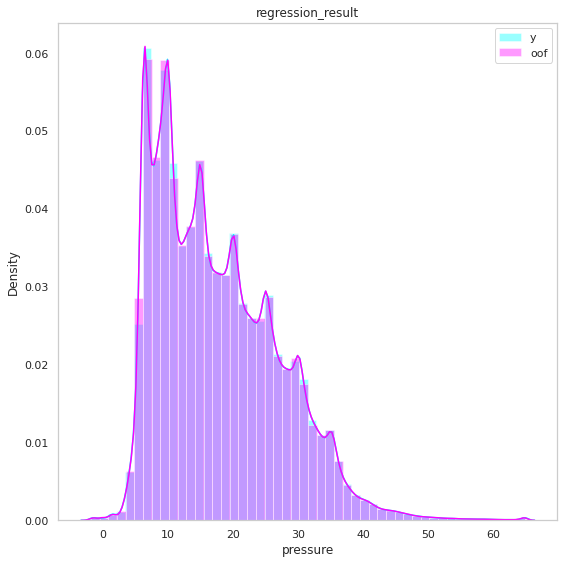

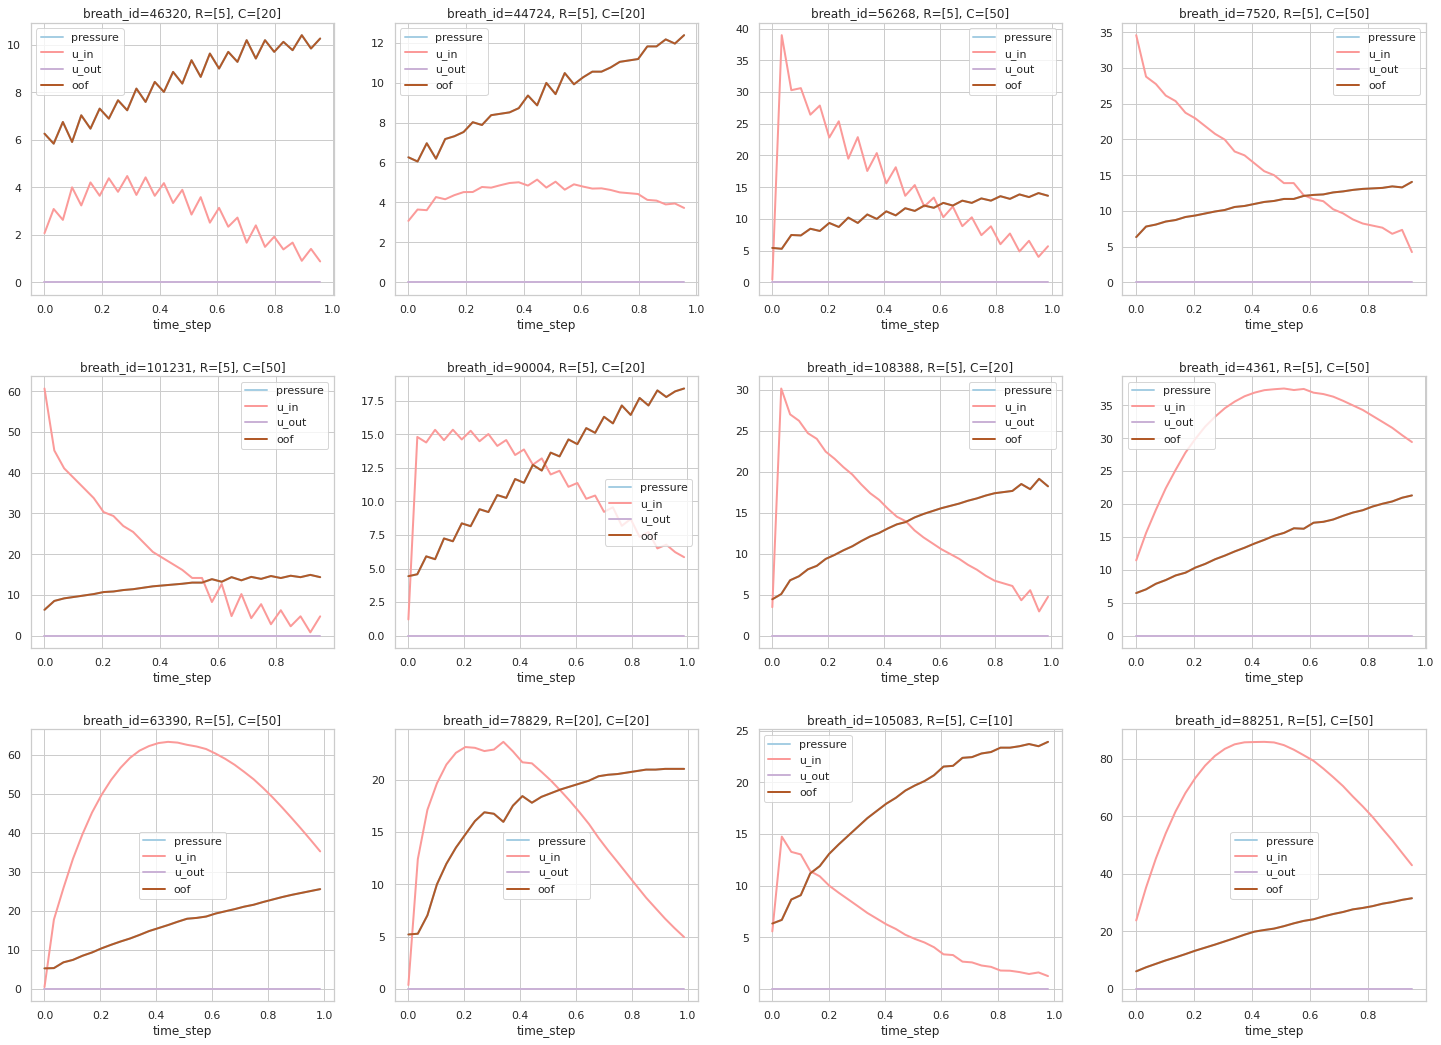

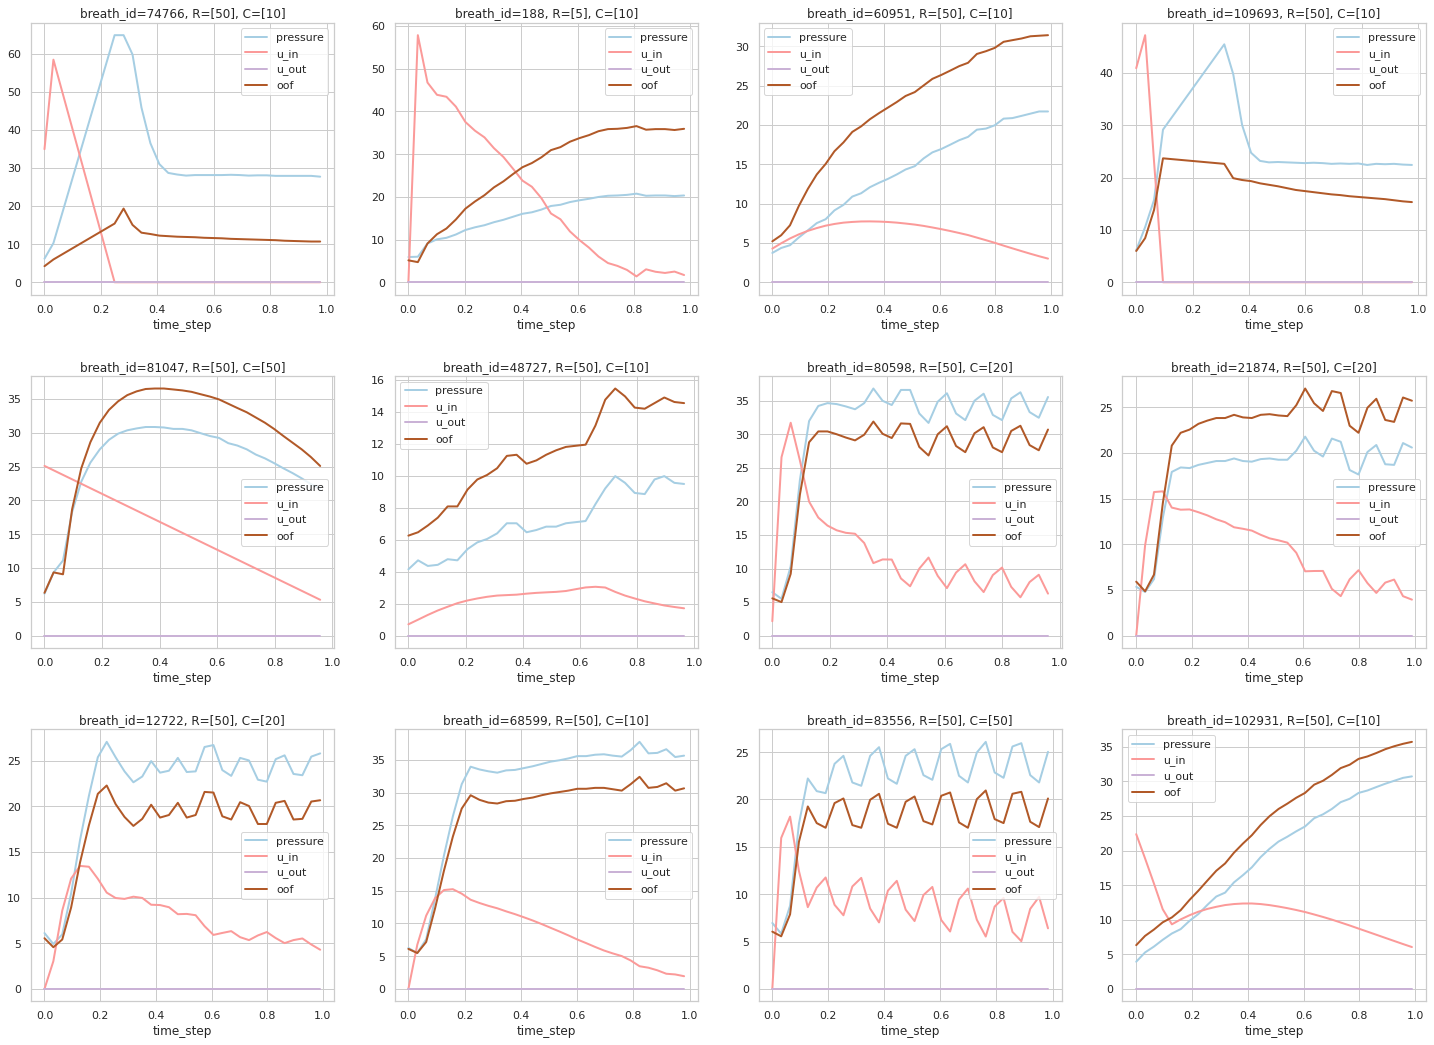

In [15]:
fig = plot_regression_result(y_true[(used_mask*mask).astype(bool)],
                             y_pred[(used_mask*mask).astype(bool)], 
                             directory=EXP_FIG)
fig.savefig(os.path.join(EXP_FIG, "regression_result.png"), dpi=300)

train["oof"] = y_pred

# plot oof score (good & bad)
train_ = train[(used_mask*mask).astype(bool)].reset_index(drop=True)
oof_score_by_breath =train_.groupby("breath_id").apply(lambda x: metrics(x["pressure"], x["oof"], x["u_out"]==0))

# best12
breath_id_for_plot = oof_score_by_breath.sort_values().index[list(range(12))]
fig = plot_pressure_line(train_, breath_ids=list(breath_id_for_plot), additional_cols=["oof"])
fig.savefig(os.path.join(EXP_FIG, "best_oof.png"), dpi=300)

# bad12
breath_id_for_plot = oof_score_by_breath.sort_values(ascending=False).index[list(range(12))]
fig = plot_pressure_line(train_, breath_ids=list(breath_id_for_plot), additional_cols=["oof"])
fig.savefig(os.path.join(EXP_FIG, "bad_oof.png"), dpi=300)

In [16]:
def show_oof_score(train):
    train_df = train.copy()

    def _get_score_by_rc(input_df, fold):
        info_lst = []
        for rc in input_df["R-C"].unique():
            rc_df = input_df[input_df["R-C"] == rc].reset_index(drop=True)
            score = metrics(rc_df["pressure"].values, rc_df["oof"].values, mask=rc_df["u_out"]==0)
            info_lst.append([f"fold={fold}", rc, score])
            
        score = metrics(input_df["pressure"].values, input_df["oof"].values, mask=input_df["u_out"]==0)
        info_lst.append([f"fold={fold}", "all", score])
        return info_lst

    train_df["R-C"] = train["R"].astype(str) + "-" + train["C"].astype(str)
    plot_info = []
    for f in train_df["fold"].unique():
        if f == -1:
            continue
        fold_df = train_df[train_df["fold"] == f].reset_index(drop=True)
        info_lst = _get_score_by_rc(fold_df, fold=f)
        plot_info += info_lst
    
    info_lst =  _get_score_by_rc(train_df, fold="ALL")
    plot_info += info_lst
        
    plot_df = pd.DataFrame(plot_info, columns=["fold", "R-C", "MAE"])
    plot_df = plot_df.sort_values(["fold", "R-C"]).reset_index(drop=True)
    fig = px.bar(plot_df, x="fold", y="MAE", color='R-C', barmode='group')

    return plot_df, fig


In [17]:
df, fig =  show_oof_score(train_)  
fig.show()
fig.write_html(os.path.join(EXP_FIG, "oof_score.html"))
display(df)

,fold,R-C,MAE
0,fold=0,20-10,0.127054
1,fold=0,20-20,0.117385
2,fold=0,20-50,0.109070
3,fold=0,5-10,0.122241
4,fold=0,5-20,0.079007
...,...,...,...
305,fold=ALL,5-50,0.088411
306,fold=ALL,50-10,0.120151
307,fold=ALL,50-20,0.195569
308,fold=ALL,50-50,0.196020


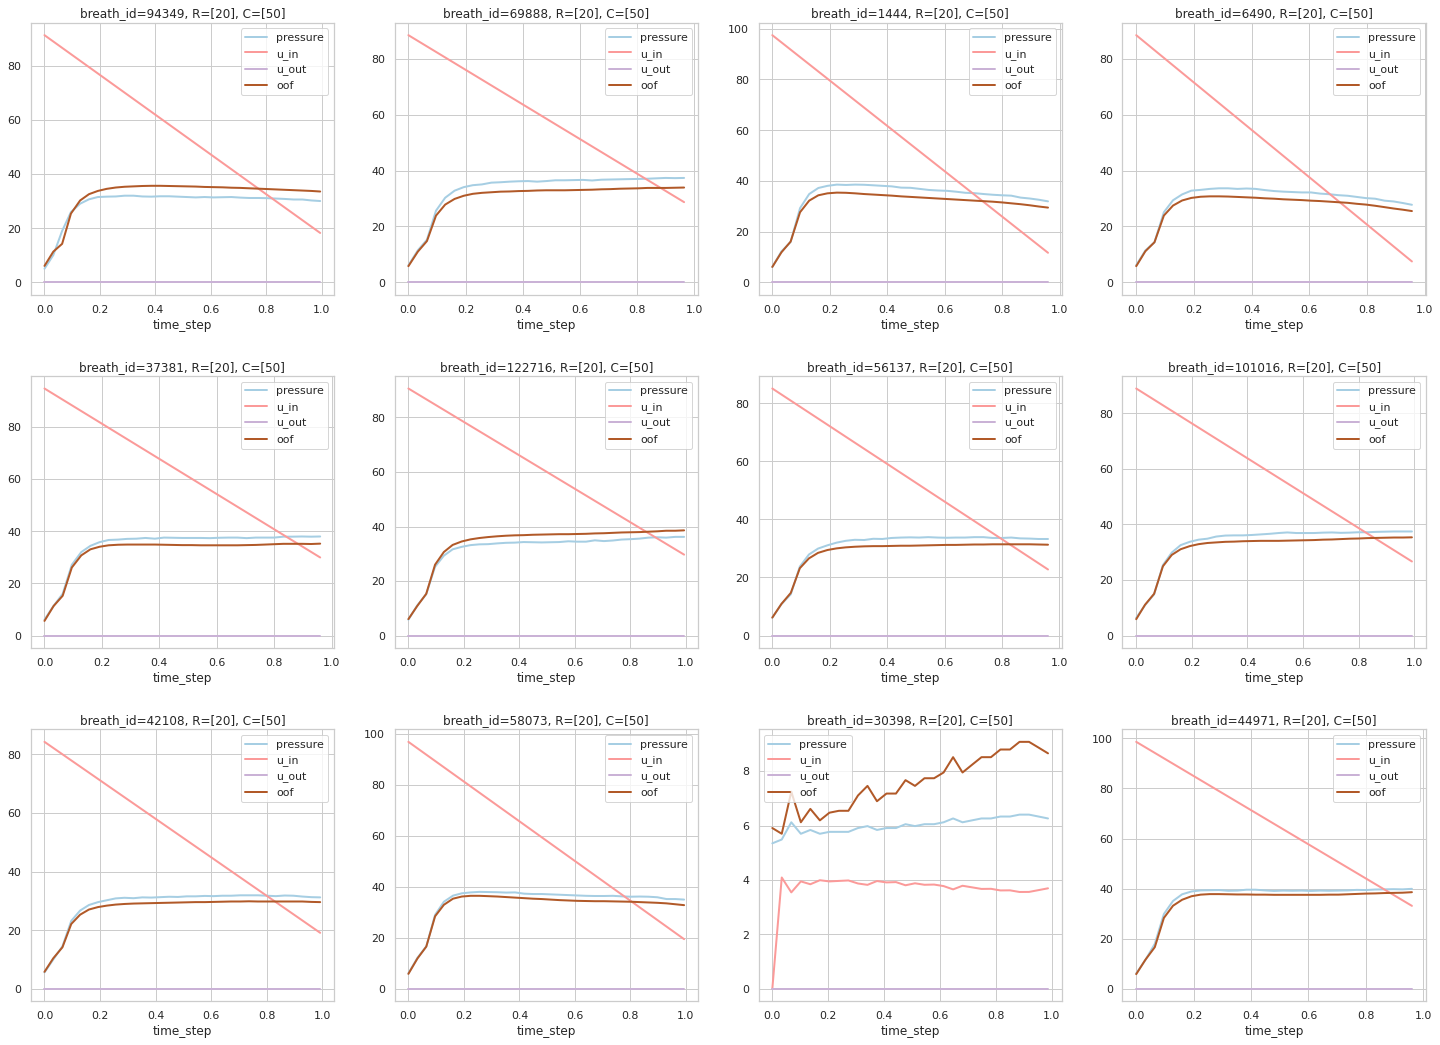

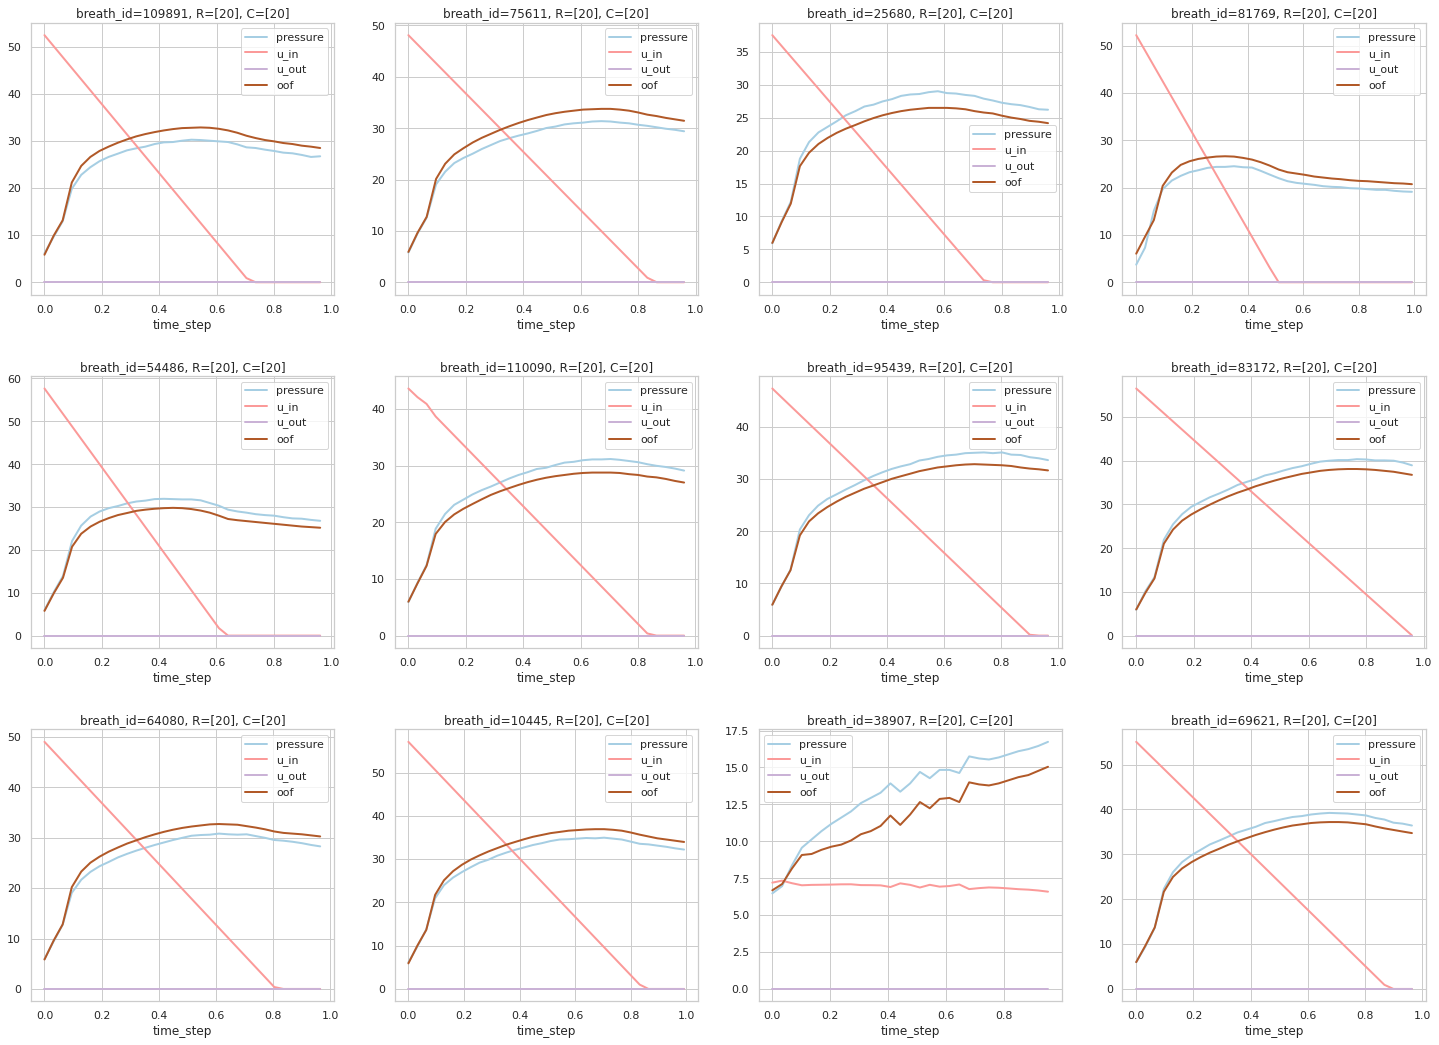

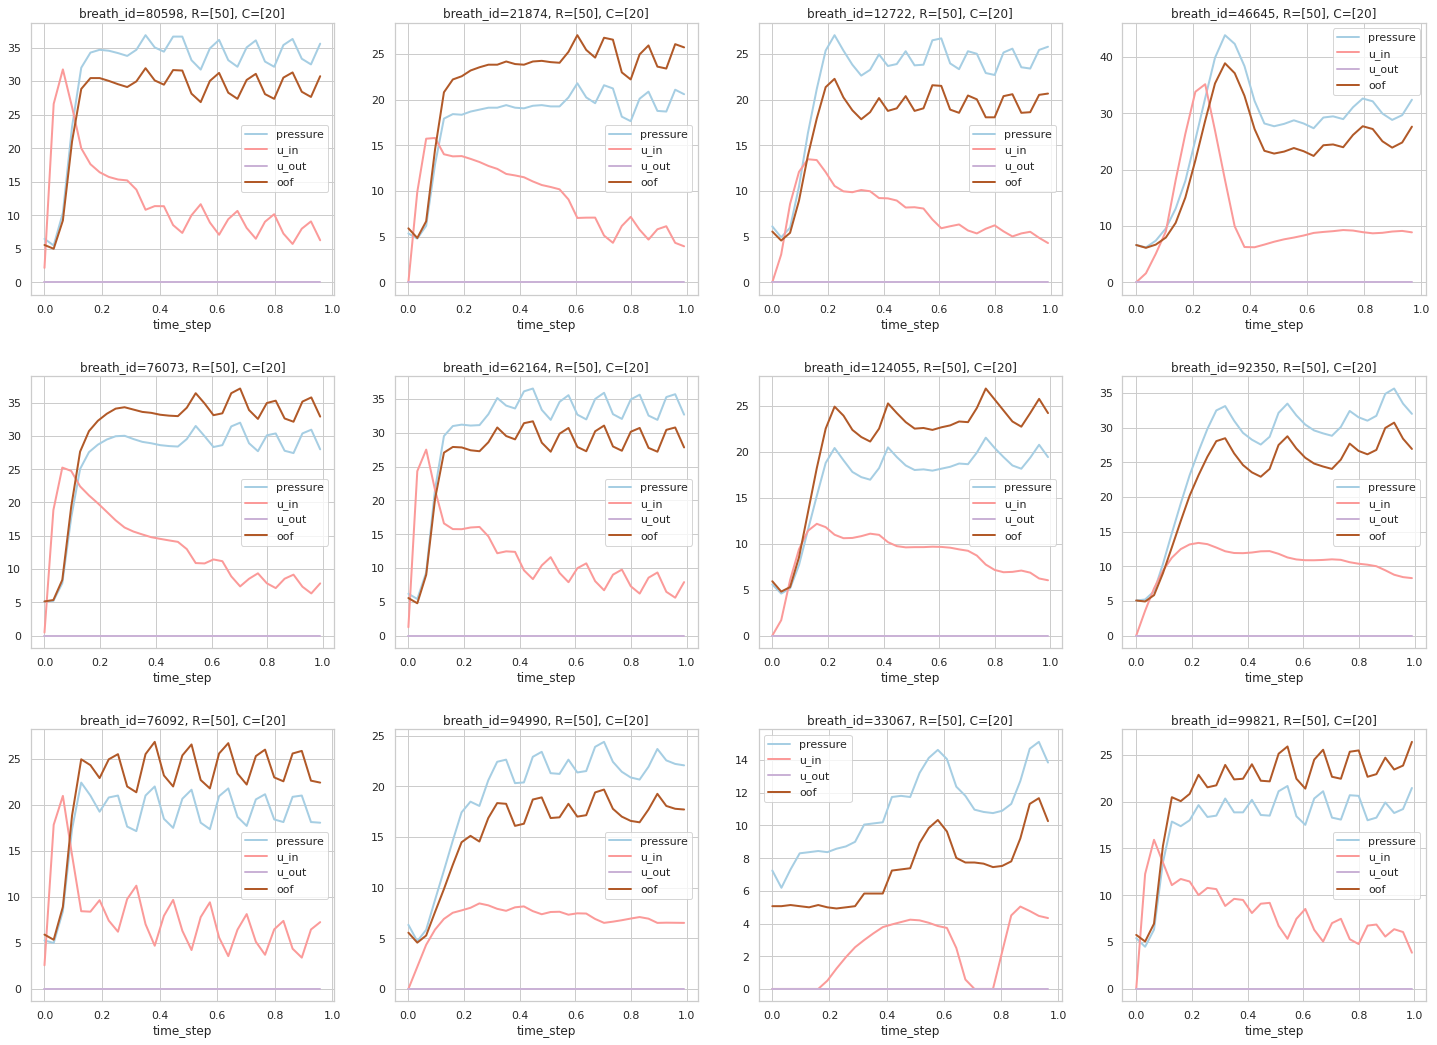

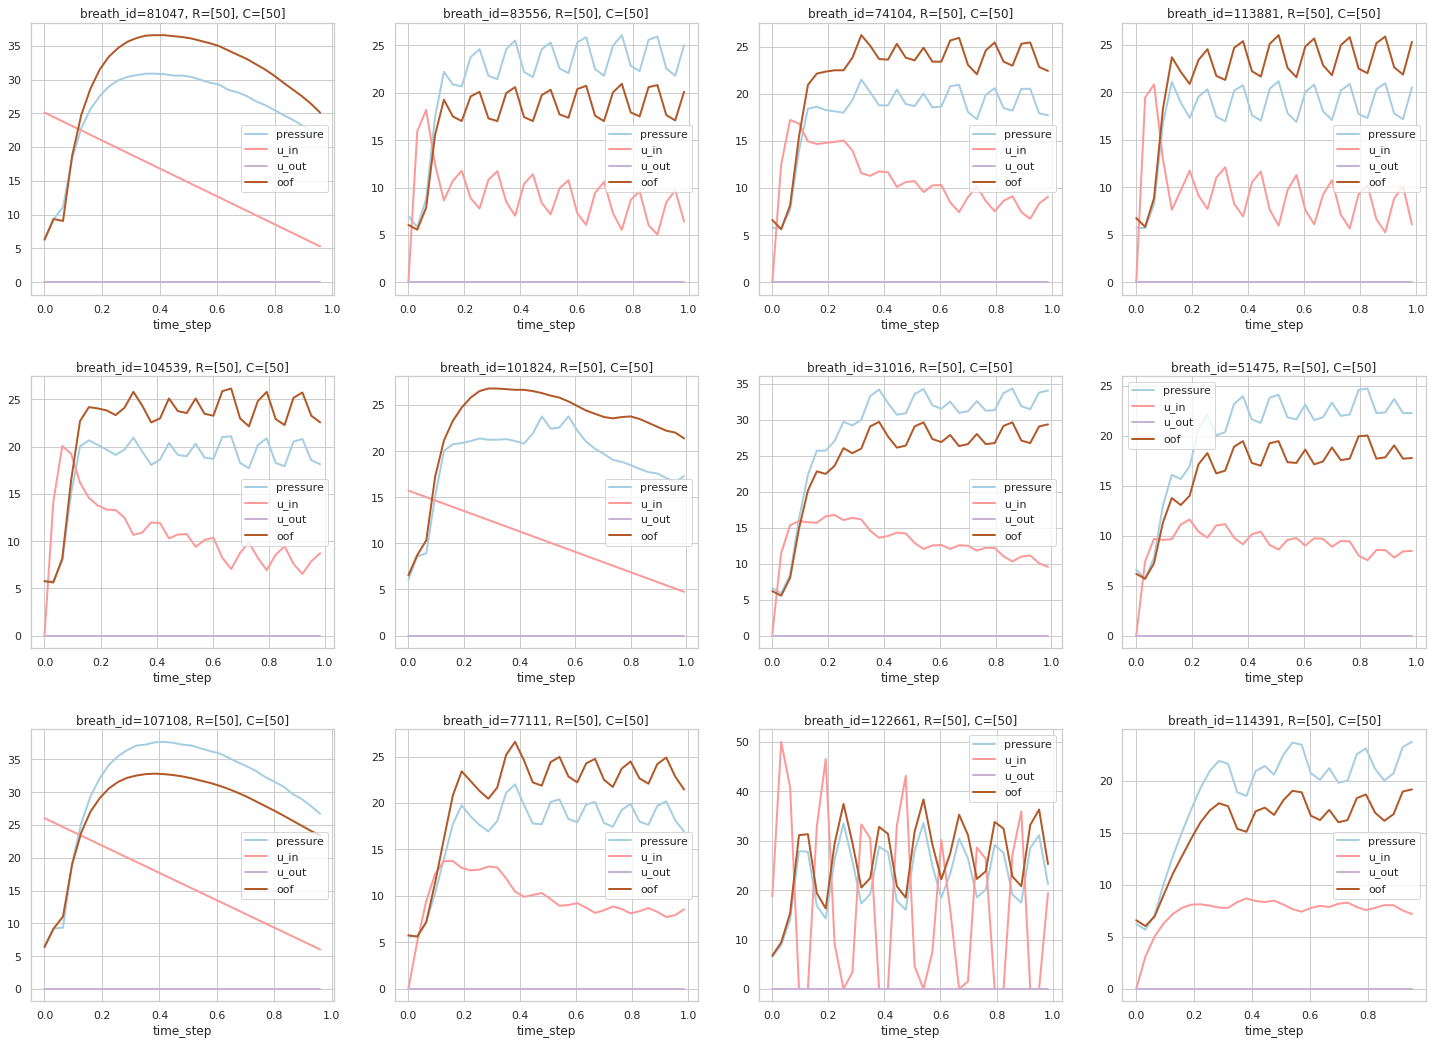

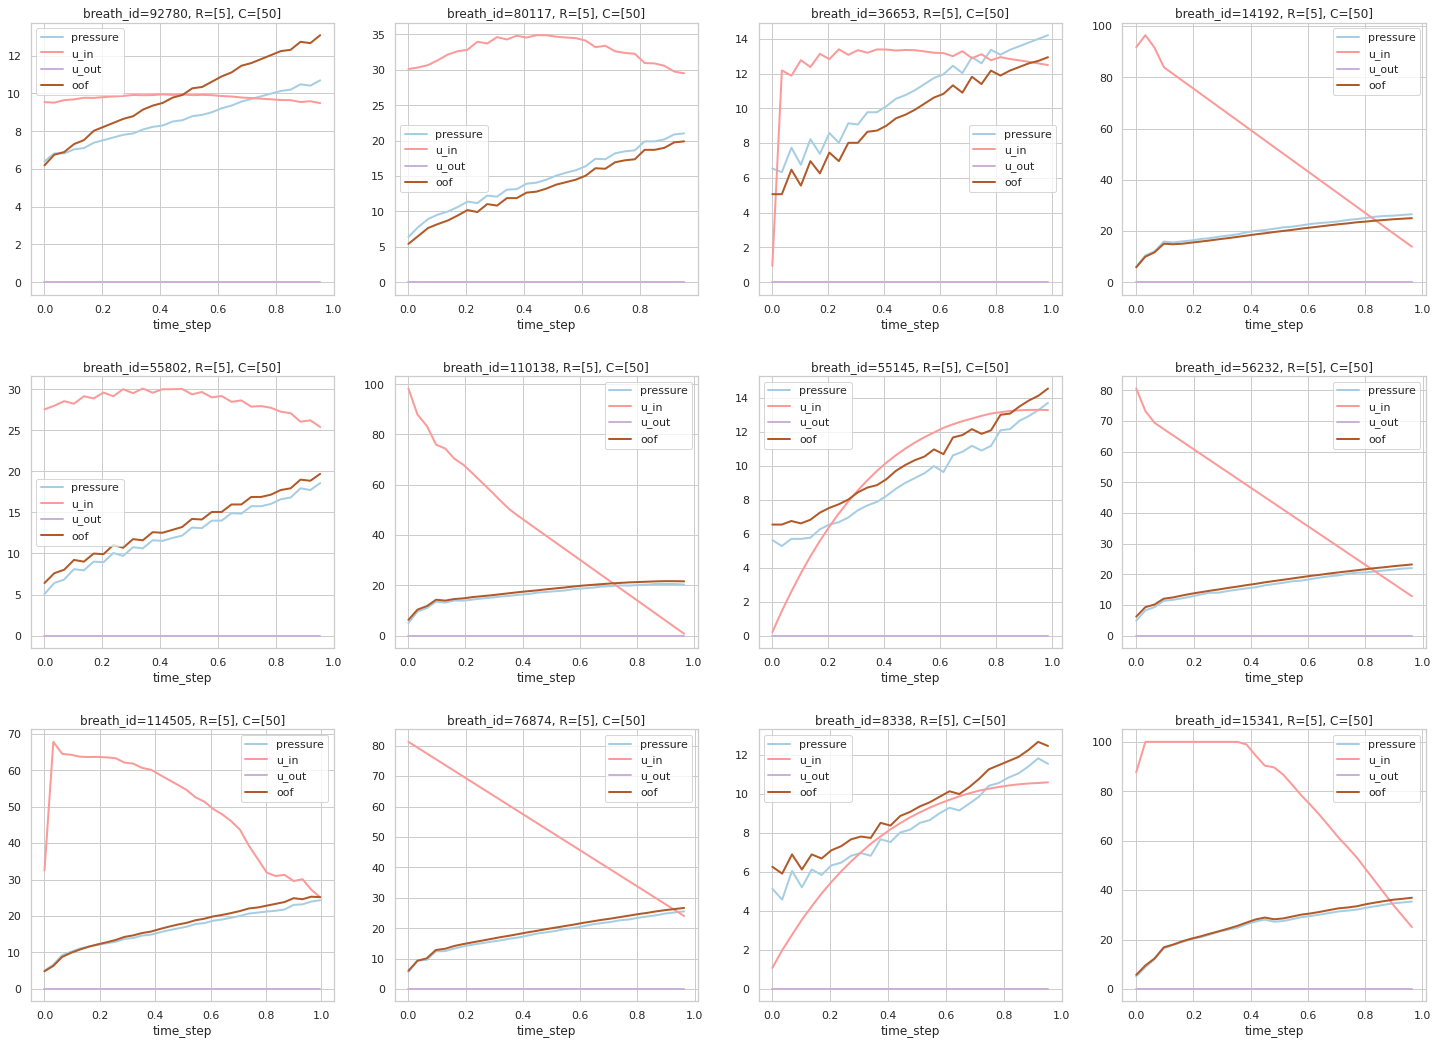

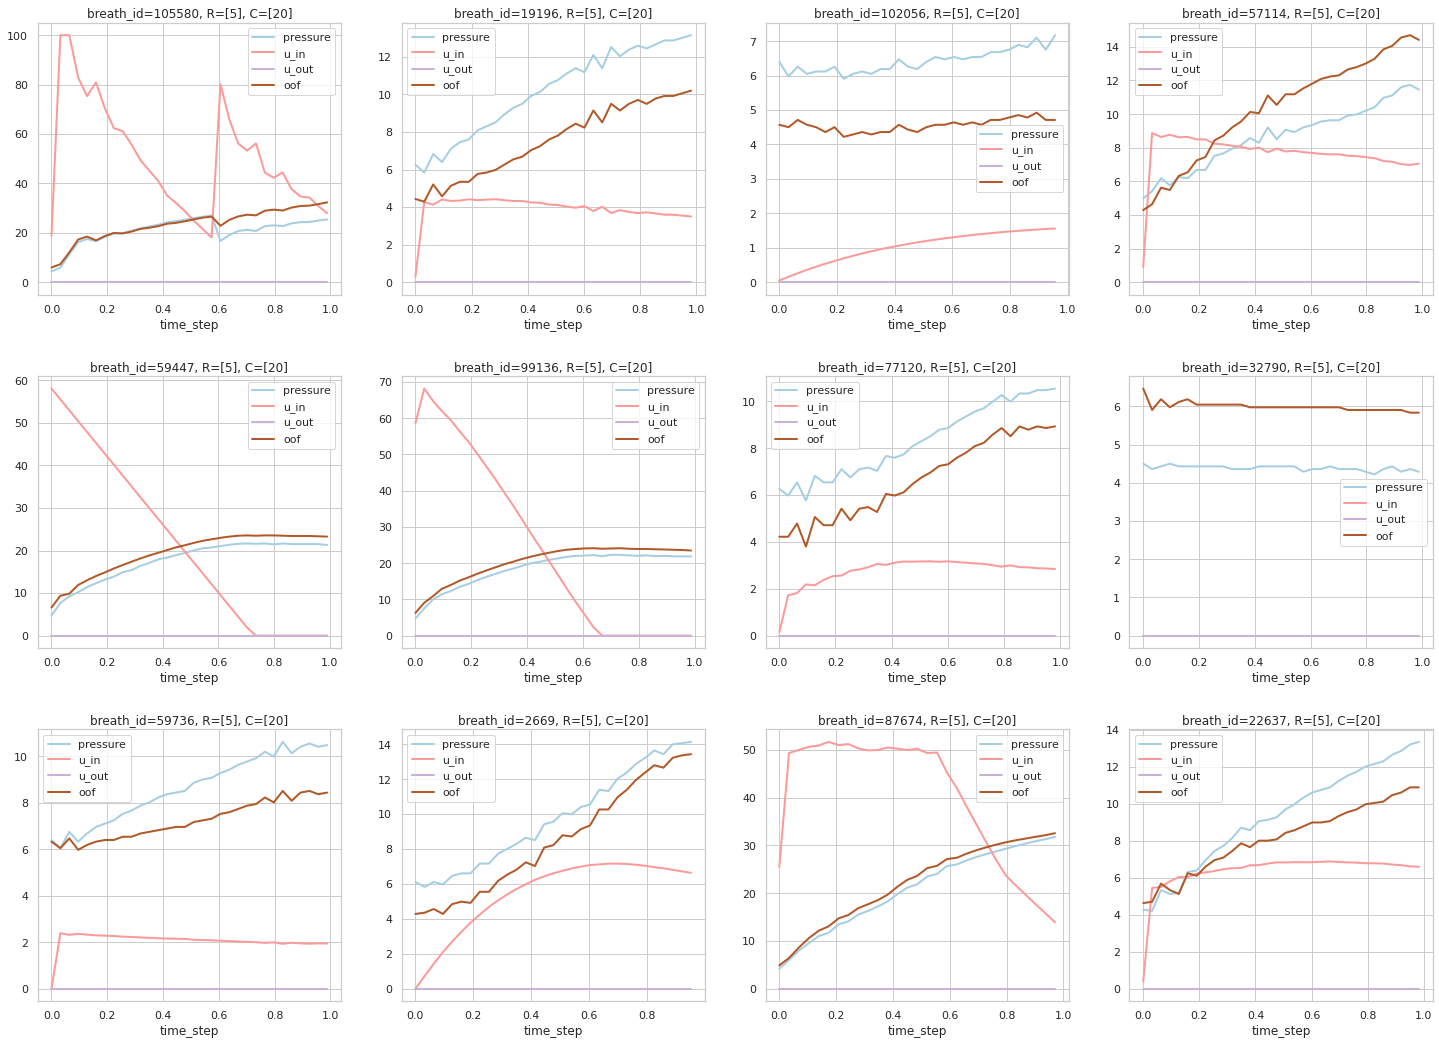

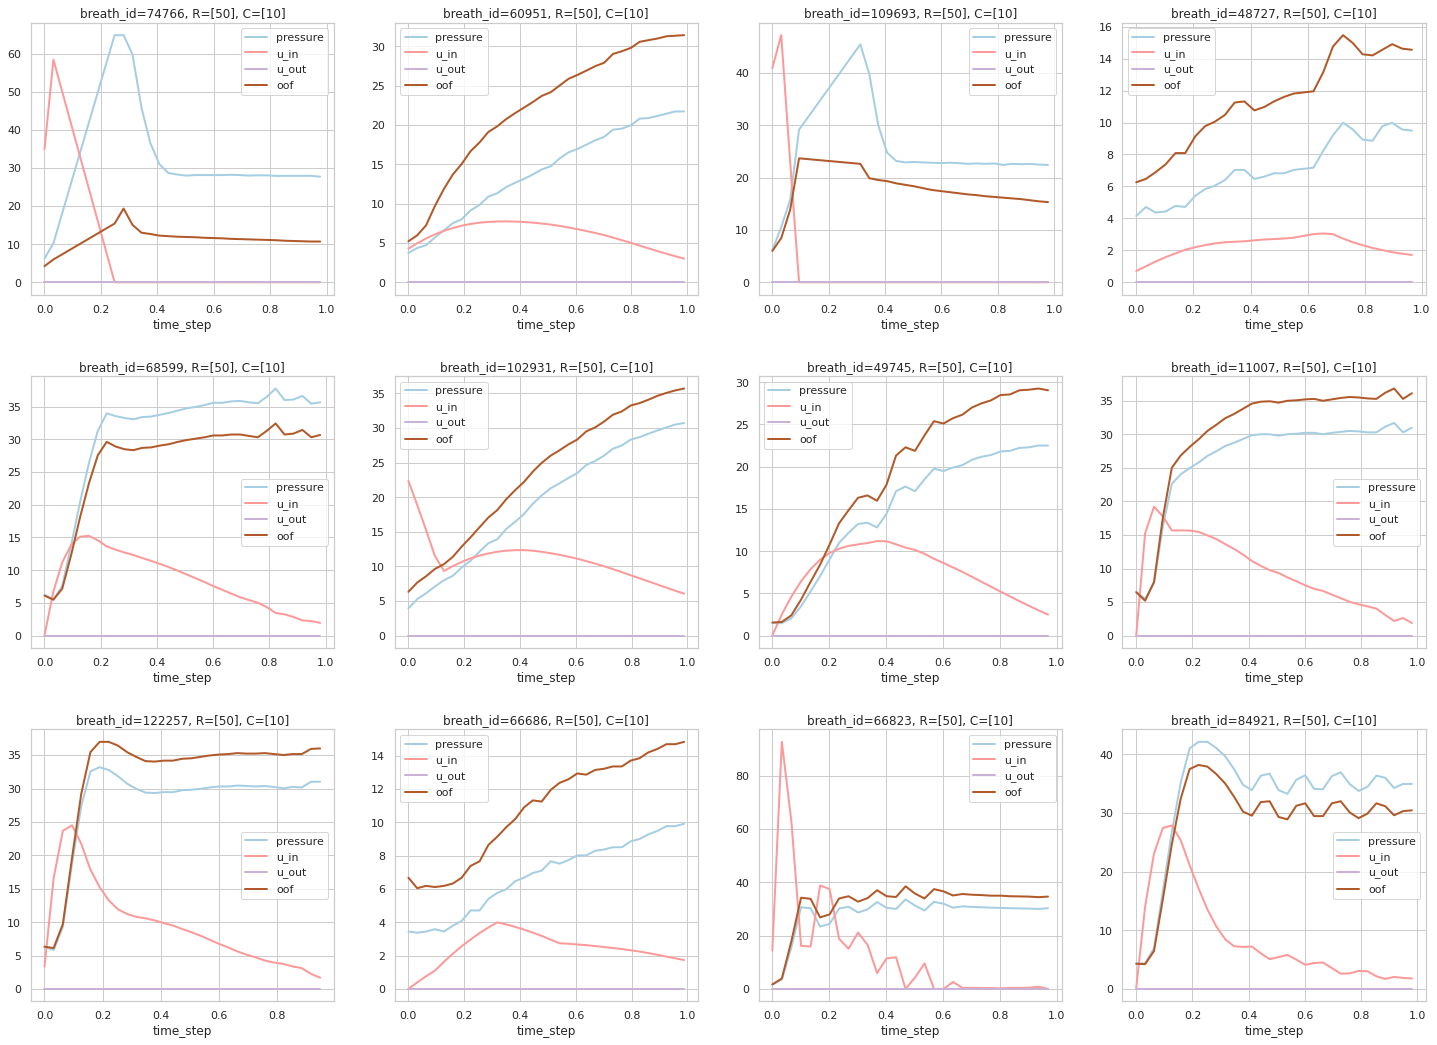

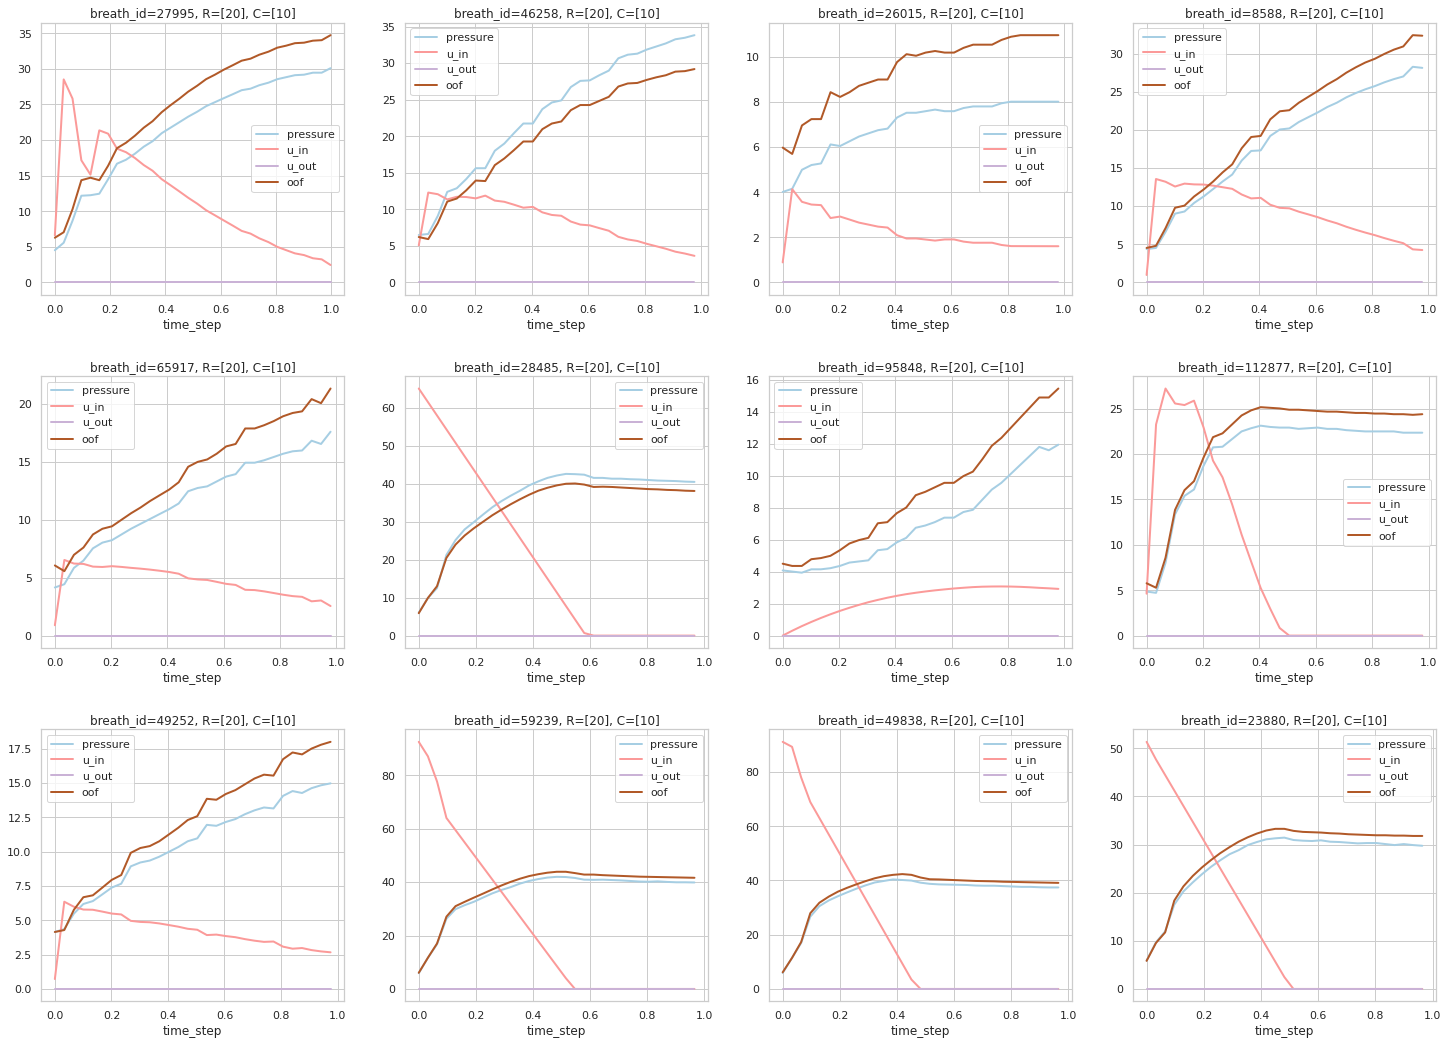

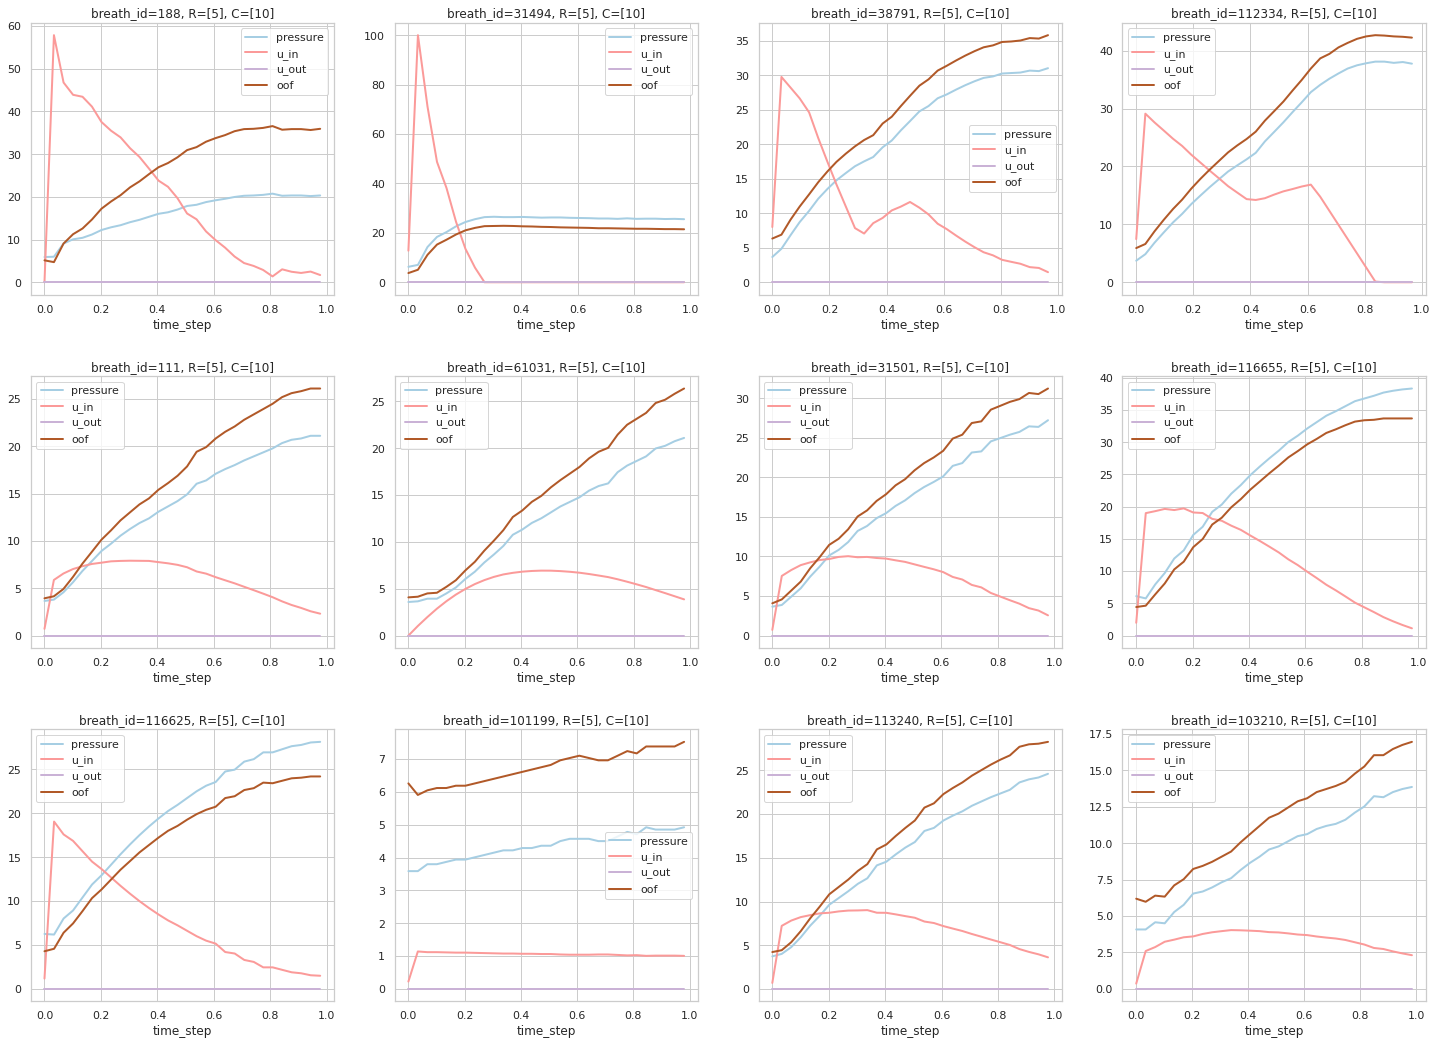

In [18]:
# plot bad predictions by R & C
train_df_by_breath = (pd.merge(
    pd.DataFrame(oof_score_by_breath, columns=["MAE"]),
    train_[["breath_id", "R", "C"]].groupby("breath_id").head(1),
    on="breath_id", how="left"))
train_df_by_breath["R-C"] = train_df_by_breath["R"].astype(str) + "-" + train_df_by_breath["C"].astype(str)

bad12_by_rc_dict = {}
for rc in train_df_by_breath["R-C"].unique():
    _df = train_df_by_breath[train_df_by_breath["R-C"] == rc].reset_index(drop=True)
    breath_ids = _df.sort_values("MAE", ascending=False)["breath_id"].tolist()[:12]
    bad12_by_rc_dict[rc] = breath_ids

    fig = plot_pressure_line(train_, breath_ids=bad12_by_rc_dict[rc], additional_cols=["oof"])
    plt.plot()
    fig.savefig(os.path.join(EXP_FIG, f"bad_oof_rc_{rc}.png"), dpi=300)

## Submission

In [19]:
filepath = os.path.join(SUBMISSION, f"{Config.name_v1}.csv")
sample_submission.to_csv(filepath, index=False)
message = f"train-fold-num:{len(Config.trn_fold)},oof-score:{oof_score:.5f},oof-score-all:{oof_score_all:.5f}"
logger.info(message)

if Config.submit_from_colab:
    ! kaggle competitions submit -c ventilator-pressure-prediction -f $filepath -m $message

[2021-11-04 09:32:37] - train-fold-num:30,oof-score:0.13020,oof-score-all:0.14438


In [20]:
# upload output folder to kaggle dataset
if Config.upload_from_colab:
    from kaggle.api.kaggle_api_extended import KaggleApi

    def dataset_create_new(dataset_name, upload_dir):
        dataset_metadata = {}
        dataset_metadata['id'] = f'{os.environ["KAGGLE_USERNAME"]}/{dataset_name}'
        dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
        dataset_metadata['title'] = dataset_name
        with open(os.path.join(upload_dir, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
        api = KaggleApi()
        api.authenticate()
        api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode='tar')

    if len(EXP) >= 50:
        dataset_name = EXP[:7]

    dataset_create_new(dataset_name=dataset_name, upload_dir=OUTPUT_EXP)